In [40]:
%%HTML
<style>
    body {
        --vscode-font-family: "Roboto Thin"
    }
</style>

In [41]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    AmbientLights,
    DirectionalLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    )
from pytorch3d.renderer.blending import BlendParams
from sugar_scene.gs_model import GaussianSplattingWrapper
from sugar_scene.sugar_model import SuGaR, load_refined_model
from sugar_utils.spherical_harmonics import SH2RGB

In [42]:
numGPU = 0
torch.cuda.set_device(numGPU)

# Load data and vanilla Gaussian Splatting

In [43]:
# ========== Loading parameters ==========
use_eval_split = False
n_skip_images_for_eval_split = 8

iteration_to_load = 7000
# iteration_to_load = 30_000

load_gt_images = True
use_custom_bbox = False

Choose a data directory (the directory that contains the images subdirectory).

In [44]:
# Example
source_path = './dataset/resized/'

Choose a corresponding vanilla Gaussian Splatting checkpoint directory.

In [45]:
# Example
gs_checkpoint_path = './output/vanilla_gs/resized/'

Load data and 3DGS checkpoint.

In [46]:
# ====================Load NeRF model and training data====================

# Load Gaussian Splatting checkpoint 
print(f"\nLoading config {gs_checkpoint_path}...")
if use_eval_split:
    print("Performing train/eval split...")
nerfmodel = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_checkpoint_path,
    iteration_to_load=iteration_to_load,
    load_gt_images=load_gt_images,
    eval_split=use_eval_split,
    eval_split_interval=n_skip_images_for_eval_split,
    )

print(f'{len(nerfmodel.training_cameras)} training images detected.')
print(f'The model has been trained for {iteration_to_load} steps.')
print(len(nerfmodel.gaussians._xyz) / 1e6, "M gaussians detected.")


Loading config ./output/vanilla_gs/resized/...
Found image extension .jpg
251 training images detected.
The model has been trained for 7000 steps.
1.230644 M gaussians detected.


# Render with a refined SuGaR model

Choose a corresponding refined SuGaR checkpoint directory (located in `refined/<your scene>`)

In [47]:
# Example
refined_sugar_folder = "./output/refined/resized/sugarfine_3Dgs7000_linear_supervised_sdfestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1/"

Choose a refinement iteration to load.

In [48]:
refined_iteration_to_load = 15_000

Load the refined SuGaR checkpoint.

In [49]:
refined_sugar_path = os.path.join(refined_sugar_folder, f"{refined_iteration_to_load}.pt")
print(f"\nLoading config {refined_sugar_path}...")

refined_sugar = load_refined_model(refined_sugar_path, nerfmodel)
cameras_to_use = nerfmodel.training_cameras


Loading config ./output/refined/resized/sugarfine_3Dgs7000_linear_supervised_sdfestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1/15000.pt...
Loading refined model...
1362931 faces detected.
1362931 gaussians detected.
1 gaussians per surface triangle detected.
Binding radiance cloud to surface mesh...


Render an image.

# Render no texture mesh

Select the path to the textured mesh (i.e. the obj file in `refined_mesh/<your scene>`).<br>
If None, the path to the mesh will be automatically computed from the checkpoint path.

In [50]:
refined_mesh_path = None

Load mesh.

Rendering image 96
Image ID: 000097
Loading no texture ply from ./output/coarse_mesh/resized/sugarmesh_3Dgs7000_const_0_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply, this could take a minute...
Loaded textured mesh with 712206 vertices and 1350966 faces.
Loading no texture ply from ./output/coarse_mesh/resized/sugarmesh_3Dgs7000_linear_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply, this could take a minute...
Loaded textured mesh with 731391 vertices and 1385863 faces.
Loading no texture ply from ./output/coarse_mesh/resized/sugarmesh_3Dgs7000_linear2_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply, this could take a minute...
Loaded textured mesh with 714389 vertices and 1354995 faces.
Loading no texture ply from ./output/coarse_mesh/resized/sugarmesh_3Dgs7000_linear3_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply, this could take a minute...
Loaded textured mesh with 719442 vertices and 1363768 faces.
Loading no texture ply from ./output/coar

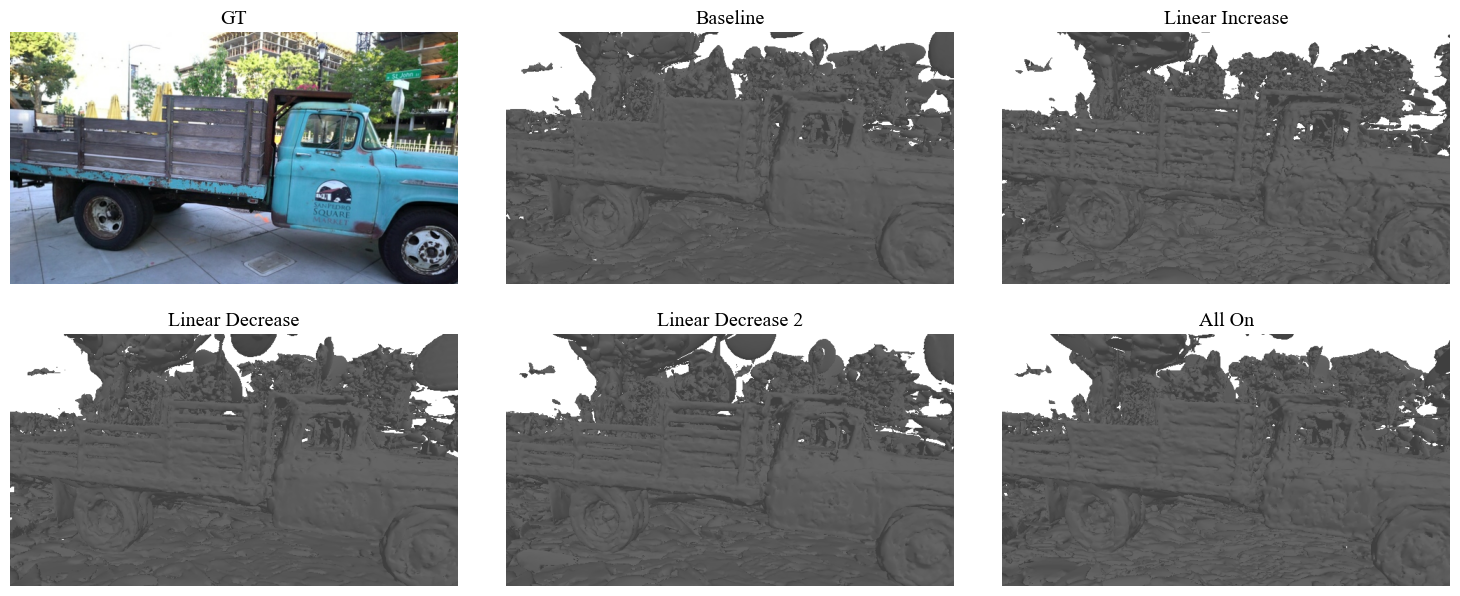

In [51]:
if refined_mesh_path is None:
    post_processed = False

    if post_processed:
        post_processed_str = '_postprocessed'
    else:
        post_processed_str = ''

    scene_name = refined_sugar_path.split('/')[-3]
    refined_mesh_dir = './output/refined_mesh'
    refined_mesh_path = os.path.join(
        refined_mesh_dir, scene_name,
        refined_sugar_path.split('/')[-2].split('.')[0] + '.obj'
    )

from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex


ply_list = {
    "Baseline": "./output/coarse_mesh/resized/sugarmesh_3Dgs7000_const_0_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply",
    "Linear Increase": "./output/coarse_mesh/resized/sugarmesh_3Dgs7000_linear_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply",
    "Linear Decrease": "./output/coarse_mesh/resized/sugarmesh_3Dgs7000_linear2_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply",
    "Linear Decrease 2": "./output/coarse_mesh/resized/sugarmesh_3Dgs7000_linear3_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply",
    "All On": "./output/coarse_mesh/resized/sugarmesh_3Dgs7000_custom_3_supervised_sdfestim02_sdfnorm02_level03_decim1000000.ply"
}

cam_idx=96
faces_per_pixel = 1
max_faces_per_bin = 50_000
mesh_raster_settings = RasterizationSettings(
    image_size=(refined_sugar.image_height, refined_sugar.image_width),
    blur_radius=0.0, 
    faces_per_pixel=faces_per_pixel,
    # max_faces_per_bin=max_faces_per_bin
)
lights = DirectionalLights(
    device=nerfmodel.device,
    direction=[[0.0, 1.0, -1.0]]  # 从右上往模型打光
)
rasterizer = MeshRasterizer(
        cameras=cameras_to_use.p3d_cameras[cam_idx], 
        raster_settings=mesh_raster_settings,
    )
renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=SoftPhongShader(
        device=refined_sugar.device, 
        cameras=cameras_to_use.p3d_cameras[cam_idx],
        lights=lights,
        # blend_params=BlendParams(background_color=(0.0, 0.0, 0.0)),
        blend_params=BlendParams(background_color=(1.0, 1.0, 1.0)),
    )
)
print("Rendering image", cam_idx)
print("Image ID:", cameras_to_use.gs_cameras[cam_idx].image_name)

images = {}

from collections import OrderedDict

images = OrderedDict()
images["GT"] = nerfmodel.get_gt_image(
    camera_indices=cam_idx,
).clamp(min=0, max=1).cpu().numpy()

for name, ply_path in ply_list.items():
    print(f"Loading no texture ply from {ply_path}, this could take a minute...")
    mesh_o3d = o3d.io.read_triangle_mesh(ply_path)
    mesh_o3d.compute_vertex_normals()
    verts = torch.tensor(np.asarray(mesh_o3d.vertices), dtype=torch.float32, device=nerfmodel.device)
    faces = torch.tensor(np.asarray(mesh_o3d.triangles), dtype=torch.int64, device=nerfmodel.device)

    vcolors = torch.full_like(verts, 0.5)
    #vcolors = torch.tensor(np.asarray(mesh_o3d.vertex_colors), dtype=torch.float32, device=nerfmodel.device)
    textured_mesh = Meshes(
        verts=[verts],
        faces=[faces],
        textures=TexturesVertex(verts_features=[vcolors])
    )

    print(f"Loaded textured mesh with {len(textured_mesh.verts_list()[0])} vertices and {len(textured_mesh.faces_list()[0])} faces.")
    with torch.no_grad():
        p3d_cameras = cameras_to_use.p3d_cameras[cam_idx]
        rgb_img = renderer(textured_mesh, cameras=p3d_cameras)[0, ..., :3]
        images[name] = rgb_img.cpu().numpy()

from math import ceil
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 12  
idx = 0
plt_h = 9/2.5
plt_w = 16/2.5
h = 2
w = ceil(len(images) / 2.0)
fig, axes = plt.subplots(h, w, figsize=(plt_w * w, plt_h * h))
fig.subplots_adjust(wspace=0.001)  # Adjust column spacing
axes = axes.flatten()  # Flatten the axes array for easier indexing
for name, image in images.items():
    axes[idx].axis("off")
    axes[idx].set_title(name)
    axes[idx].imshow(image)
    idx += 1
# Hide axes for unused subplots
for i in range(idx, len(axes)):
    axes[i].axis("off")
plt.show()
torch.cuda.empty_cache()